# Introduction

Pneumonia is a global health crisis affecting vulnerable groups, such as children and the elderly. Prompt and accurate diagnosis is crucial for effective treatment. However, traditional methods relying on manual interpretation of chest X-rays are slow and vary in diagnostic accuracy.

**Technologies Used**:

**Pytorch** for load the data, build the model architeture, train it and avaliate it with new images.

**Dask** for model validation.

**Pandas and NumPy** for data manipulation and organization.

**Scikit-Learn** for confusion metrix and classification report.

**Matplotlib and Seaborn** for Data and Images Visualization

# Imports

In [1]:
import os
import time
import copy
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# PyTorch
import torch
from torch import nn
import torch.nn as nn
torch.manual_seed(42)
from torch import optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transform
from torchvision import datasets, transforms, models

# Dask
import dask
import dask.distributed as dd
from dask.distributed import Client, get_task_stream, performance_report

# Warnings off
import warnings
warnings.filterwarnings("ignore")

# 1. Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Clases Analysis

Found 1349 elements for NORMAL
Found 3883 elements for PNEUMONIA


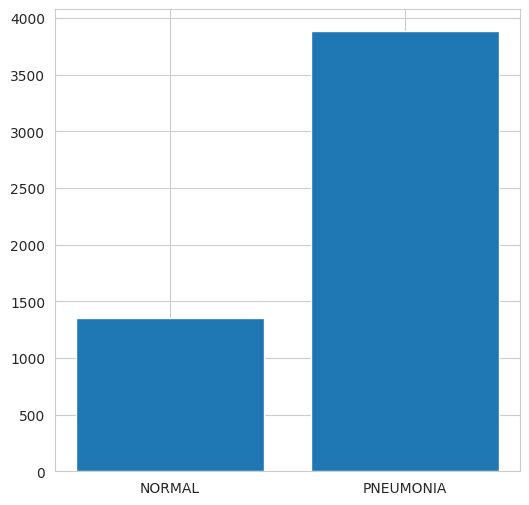

In [3]:
#Set counters
samples_train_normal    = len(os.listdir('/scratch/gohil.de/Pediatric Chest X-ray Pneumonia/train/NORMAL'))
samples_train_pneumonia = len(os.listdir('/scratch/gohil.de/Pediatric Chest X-ray Pneumonia/train/PNEUMONIA'))

# Define two dictionaries
class_names = {0: 'NORMAL', 1: 'PNEUMONIA'}
class_count = {0: samples_train_normal, 1: samples_train_pneumonia}

# Print results
print(f'Found {class_count[0]} elements for {class_names[0]}')
print(f'Found {class_count[1]} elements for {class_names[1]}')

#Plot
fig, ax = plt.subplots(figsize=(6,6))
ax.bar([class_names[0], class_names[1]], [class_count[0], class_count[1]]);

## 4. Load Train and Validation sets

In [4]:
# Set 
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(),
    transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor()
])

training_set = datasets.ImageFolder('/scratch/gohil.de/Pediatric Chest X-ray Pneumonia/train', transform = train_transform)
validation_set = datasets.ImageFolder('/scratch/gohil.de/Pediatric Chest X-ray Pneumonia/test', transform = test_transform)

In [5]:
# Batch size
batch_size = 64

# Load the datasets with DataLoader
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(validation_set,   batch_size=batch_size, shuffle=True)

## 5. Model Definition

In [6]:
# Base model (transfer learning): DenseNet-161
model = models.densenet161(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### Freeze the weights of the pre-trained model

In [7]:
for param in model.parameters():
    param.requires_grad = False

model.classifier.in_features

2208

In [8]:
# Build a custom classifier
num_classes = len(class_names)

# New classifier
classifier = nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)

# Replace the transfer learning model classifier
model.classifier = classifier

## 6. Training

### 6.1. Compile the model


In [9]:
# Loss function
loss_func = nn.CrossEntropyLoss()

# Optimizer and learning rate
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Adapter
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

### 6.2. Helper functions
#### 6.2.1. Accuracy


In [10]:
def calculate_accuracy(outputs, labels):
    _, predictions     = torch.max(outputs, dim=1)
    num_correct        = torch.sum(predictions==labels).item()
    percentage_correct = torch.tensor(num_correct/len(predictions))
    
    return percentage_correct

#### 6.2.2. Training step


In [11]:
def training_step(model, loader, loss_function):
    # Training-mode
    model.train()
    
    # For every epoch initialize loss and number of correct predictions
    epoch_loss    = 0
    epoch_correct = 0
    
    # Batch loop
    for images, labels in iter(loader):  
        # Load images and labels to 'device'  
        images, labels = images.to(device), labels.to(device)
        
        # Initialize the gradient   
        optimizer.zero_grad()
        
        # Training
        with torch.set_grad_enabled(True):
            # Output from the model (from the forward pass)   
            output = model(images)
            
            # Calculate the loss_function for the current batch   
            loss = loss_func(output, labels)
            
            # Perform the backpropagation (backpropagate the error)
            loss.backward()
            
            # Gradient descent step to update parameters (weights/biases)  
            optimizer.step()
            
            # Extract predictions 
            _, predictions = torch.max(output, dim=1)
            
        # Update loss (+= loss * num_images_in_the_batch)  
        epoch_loss += loss.item() * images.size(0)
        
        # Update correct      
        epoch_correct += torch.sum(predictions==labels)
    
    # Get the right epoch loss (element_loss / n_element)
    epoch_loss = epoch_loss / len(loader.dataset)
    
    # Accuracy of the current batch (correct / n_samples)
    accuracy = epoch_correct.double() / len(loader.dataset)
    
    return epoch_loss, accuracy

#### 6.2.3. Evaluation step

In [12]:
def evaluate_model(model, loader, loss_function):
    
    # Evaluation-mode
    model.eval()
    
    # For every epoch initialize loss and number of correct predictions
    epoch_loss = 0
    epoch_correct = 0
    
    # Batch loop
    for images, labels in iter(loader):                                             
        # Load images and labels to 'device'                                        
        images, labels = images.to(device), labels.to(device)  
        
        # Evaluation
        with torch.set_grad_enabled(False):
            
            output = model(images)
            
            # Calculate the loss_function for the current batch  
            loss = loss_func(output, labels)
            
            # Extract predictions 
            _, predictions = torch.max(output, dim=1) 
            
        # Update loss (+= loss * num_images_in_the_batch)    
        epoch_loss += loss.item()*images.size(0)     
        
        # Update correct                                                            
        epoch_correct += torch.sum(predictions==labels)
        
    # Get the right epoch loss (element_loss / n_element)
    epoch_loss = epoch_loss / len(loader.dataset)

    # Accuracy of the current batch (correct / n_samples)
    accuracy = epoch_correct.double() / len(loader.dataset)

    return epoch_loss, accuracy

### 6.3. Training


In [13]:
# Number of epochs
epochs = 5

# Monitor 'val_loss'
best_val_loss = float('inf')

# Model to device
model.to(device)

# For the records
train_loss_savings = []
train_acc_savings  = []
val_loss_savings   = []
val_acc_savings    = []

# Saving the model
best_model = copy.deepcopy(model.state_dict())

t0 = time.time()

# TRAINING
for epoch in range(epochs):
    start_time = time.time()
    # Training step
    train_loss, train_acc = training_step(model, train_loader, loss_func) 
    train_loss_savings.append(train_loss)
    train_acc_savings.append(train_acc.item())
    
    # Evaluation step
    val_loss, val_acc = evaluate_model(model, val_loader, loss_func)
    val_loss_savings.append(val_loss)
    val_acc_savings.append(val_acc.item())
    
    # Print results
    print(f'Epoch: {epoch+1:02}/{epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}')

    # If the val_loss improved, save the model
    if val_loss < best_val_loss:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss improved from {best_val_loss:.4f} to {val_loss:.4f}, new model saved')
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
    else:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss did not improve')
    print(f'Time Taken: {time.time() - start_time}')
    
    # Update scheduler (learning rate adapter)
    scheduler.step()

print(f'Total Time Taken for training: {time.time() - t0}')

Epoch: 01/5 - train_loss: 0.3127 - train_accuracy: 0.8763 - val_loss: 0.3176 - val_accuracy: 0.8638
Epoch: 01/5 - val_loss improved from inf to 0.3176, new model saved
Time Taken: 329.78373503685
Epoch: 02/5 - train_loss: 0.1751 - train_accuracy: 0.9392 - val_loss: 0.2822 - val_accuracy: 0.8942
Epoch: 02/5 - val_loss improved from 0.3176 to 0.2822, new model saved
Time Taken: 279.38151597976685
Epoch: 03/5 - train_loss: 0.1472 - train_accuracy: 0.9467 - val_loss: 0.2592 - val_accuracy: 0.8958
Epoch: 03/5 - val_loss improved from 0.2822 to 0.2592, new model saved
Time Taken: 210.7466802597046
Epoch: 04/5 - train_loss: 0.1374 - train_accuracy: 0.9511 - val_loss: 0.2693 - val_accuracy: 0.8974
Epoch: 04/5 - val_loss did not improve
Time Taken: 169.76094961166382
Epoch: 05/5 - train_loss: 0.1199 - train_accuracy: 0.9551 - val_loss: 0.2738 - val_accuracy: 0.8926
Epoch: 05/5 - val_loss did not improve
Time Taken: 165.5826723575592
Total Time Taken for training: 1155.2566983699799


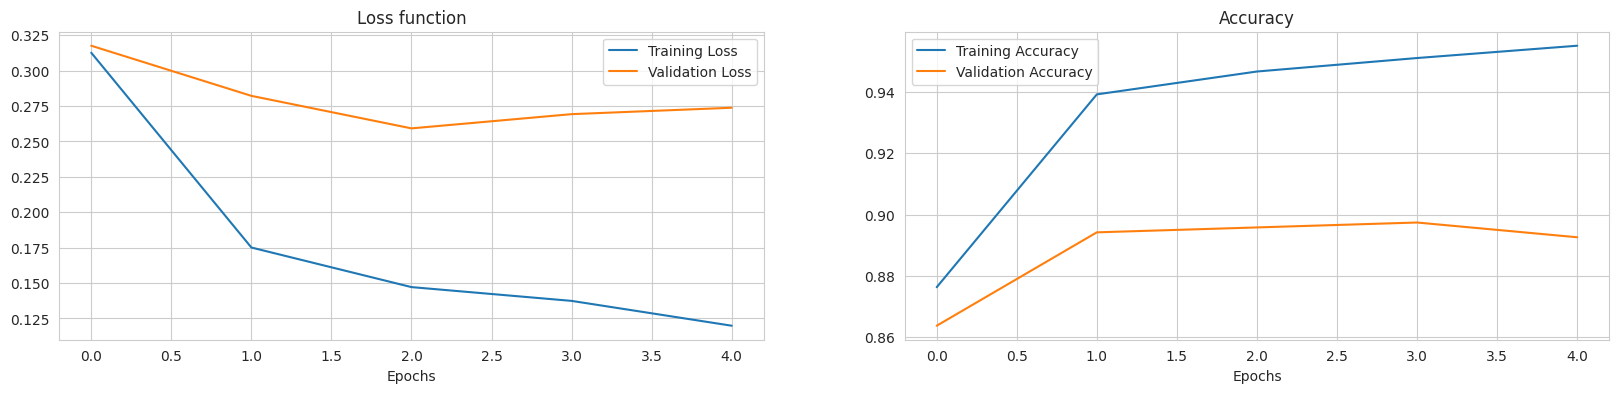

In [14]:
# Trends
plt.figure(figsize=(20,4));

# Loss function
plt.subplot(1,2,1)
plt.plot(train_loss_savings, label='Training Loss');
plt.plot(val_loss_savings, label='Validation Loss');
plt.title('Loss function');
plt.xlabel('Epochs');
plt.legend();

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_acc_savings, label='Training Accuracy');
plt.plot(val_acc_savings, label='Validation Accuracy');
plt.title('Accuracy');
plt.xlabel('Epochs');
plt.legend();

In [15]:
# Save the model

# Path for saving the best model
path_best_model = r'./Pediatric Chest X-ray Pneumonia/'
if not os.path.exists(path_best_model):
    os.mkdir(path_best_model)
    
# Save the model
torch.save(model.state_dict(), path_best_model + 'best-model-weighted.pt')

## 7. Prediction on test


### 7.1. Accuracy on test


In [16]:
# Load the best version of the model
model.load_state_dict(torch.load(path_best_model + 'best-model-weighted.pt'))

<All keys matched successfully>

In [17]:
def get_probs_and_preds(model, loader):
    model.eval()
    
    images_savings = []
    labels_savings = []
    probs_savings  = []
    preds_savings  = []
    
    # Batch Loop
    for images, labels in iter(loader):                                             
        images, labels = images.to(device), labels.to(device) 
        
    # Evaluation
        with torch.set_grad_enabled(False):        
            output = model(images)
            output = F.softmax(output)
            probabilities, predictions = torch.max(output, dim=1) 
        
        images_savings.append(images.cpu()) 
        labels_savings += labels.tolist()                                           
        probs_savings  += probabilities.tolist()                                    
        preds_savings  += predictions.tolist()   
        
    # Accuracy
    correct_elements = 0
    for i in range(len(labels_savings)):
        if labels_savings[i] == preds_savings[i]:
            correct_elements += 1
    accuracy = correct_elements/len(labels_savings)

    return images_savings, labels_savings, probs_savings, preds_savings, accuracy

In [18]:
# Evaluate the model on test data
images, labels, probs, preds, accuracy = get_probs_and_preds(model, val_loader)

# Print results
print(f'Accuracy on test: {accuracy:.4f}')

Accuracy on test: 0.8926


### Dask Delayed for model Validation on different worker size

In [19]:
# Use Dask's delayed function to parallelize evaluation
@dask.delayed
def evaluate_model_dask(model, loader):
    start_time = time.time()
    result = get_probs_and_preds(model, loader)
    elapsed_time = time.time() - start_time
    return elapsed_time, result

# Create a Dask client and cluster
cluster = dd.LocalCluster(n_workers=16)
client = dd.Client(cluster)

# Run evaluation on the test data with different numbers of workers
results = []
for n_workers in [1, 2, 4, 8, 16]:
    with dask.config.set(scheduler='threads', num_workers=n_workers), performance_report(filename=f"dask_performance_report_{n_workers}.html"):
        evaluation_delayed = evaluate_model_dask(model, val_loader)
        elapsed_time, (images_savings, labels_savings, probs_savings, preds_savings, accuracy) = evaluation_delayed.compute()
        results.append((n_workers, elapsed_time, accuracy))
        print(f"Number of workers: {n_workers}, Elapsed time: {elapsed_time}")

# Shutdown Dask client and cluster
client.close()
cluster.close()


Number of workers: 1, Elapsed time: 16.553321599960327
Number of workers: 2, Elapsed time: 15.895400524139404
Number of workers: 4, Elapsed time: 16.773422956466675
Number of workers: 8, Elapsed time: 16.51034188270569
Number of workers: 16, Elapsed time: 16.066898822784424


In [20]:
worker_arr = [item[0] for item in results]

dask_time = [item[1] for item in results]
speedup = [worker_time / dask_time[0] for worker_time in dask_time]
efficiency = np.array(speedup) / np.array(worker_arr)

print(f"Workers: {worker_arr}")
print(f"Time Taken by each Workers: {dask_time}")
print(f"Speed Up of each Workers: {speedup}")
print(f"Efficiency of each Workers: {efficiency}")

Workers: [1, 2, 4, 8, 16]
Time Taken by each Workers: [16.553321599960327, 15.895400524139404, 16.773422956466675, 16.51034188270569, 16.066898822784424]
Speed Up of each Workers: [1.0, 0.9602544376457653, 1.013296506998745, 0.9974035593403355, 0.9706147932764703]
Efficiency of each Workers: [1.         0.48012722 0.25332413 0.12467544 0.06066342]


### Dask: Number of CPUs Vs Time Taken Grpah

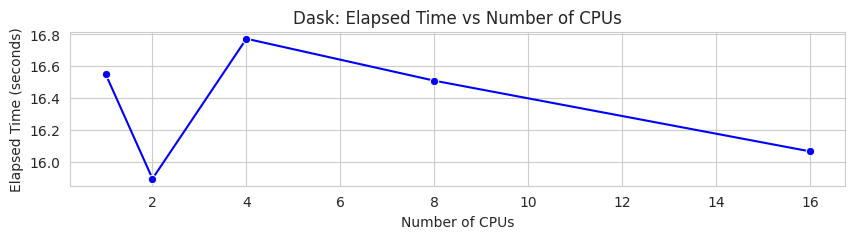

In [21]:
plt.figure(figsize=(10, 2))

sns.lineplot(x=worker_arr, y=dask_time, marker='o', color='blue')

plt.xlabel('Number of CPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.title('Dask: Elapsed Time vs Number of CPUs')

plt.show()

### Das: Number of CPUs Vs Speed Up Grpah

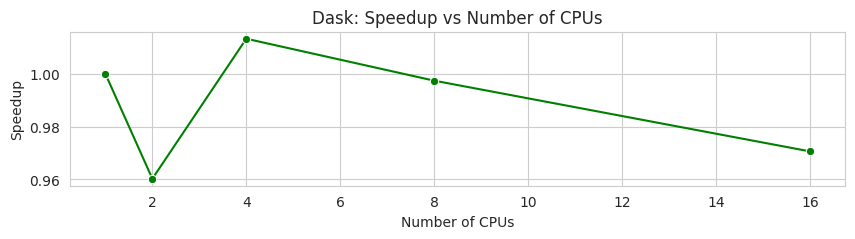

In [22]:
plt.figure(figsize=(10, 2))
sns.lineplot(x=worker_arr, y=speedup, marker='o', color='green')
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.title('Dask: Speedup vs Number of CPUs')
plt.show()

### Dask: Number of CPUs Vs Efficiency Grpah

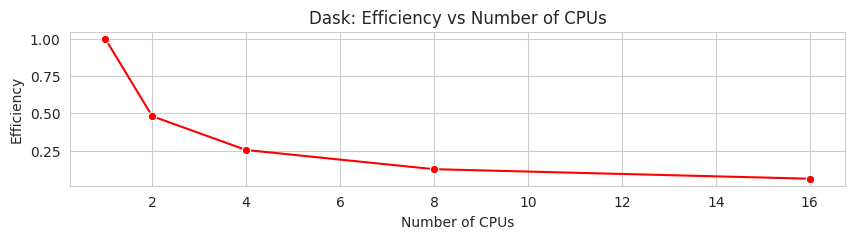

In [23]:
plt.figure(figsize=(10, 2))
sns.lineplot(x=worker_arr, y=efficiency, marker='o', color='red')
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.title('Dask: Efficiency vs Number of CPUs')
plt.show()

### 7.2. Visualization of the results


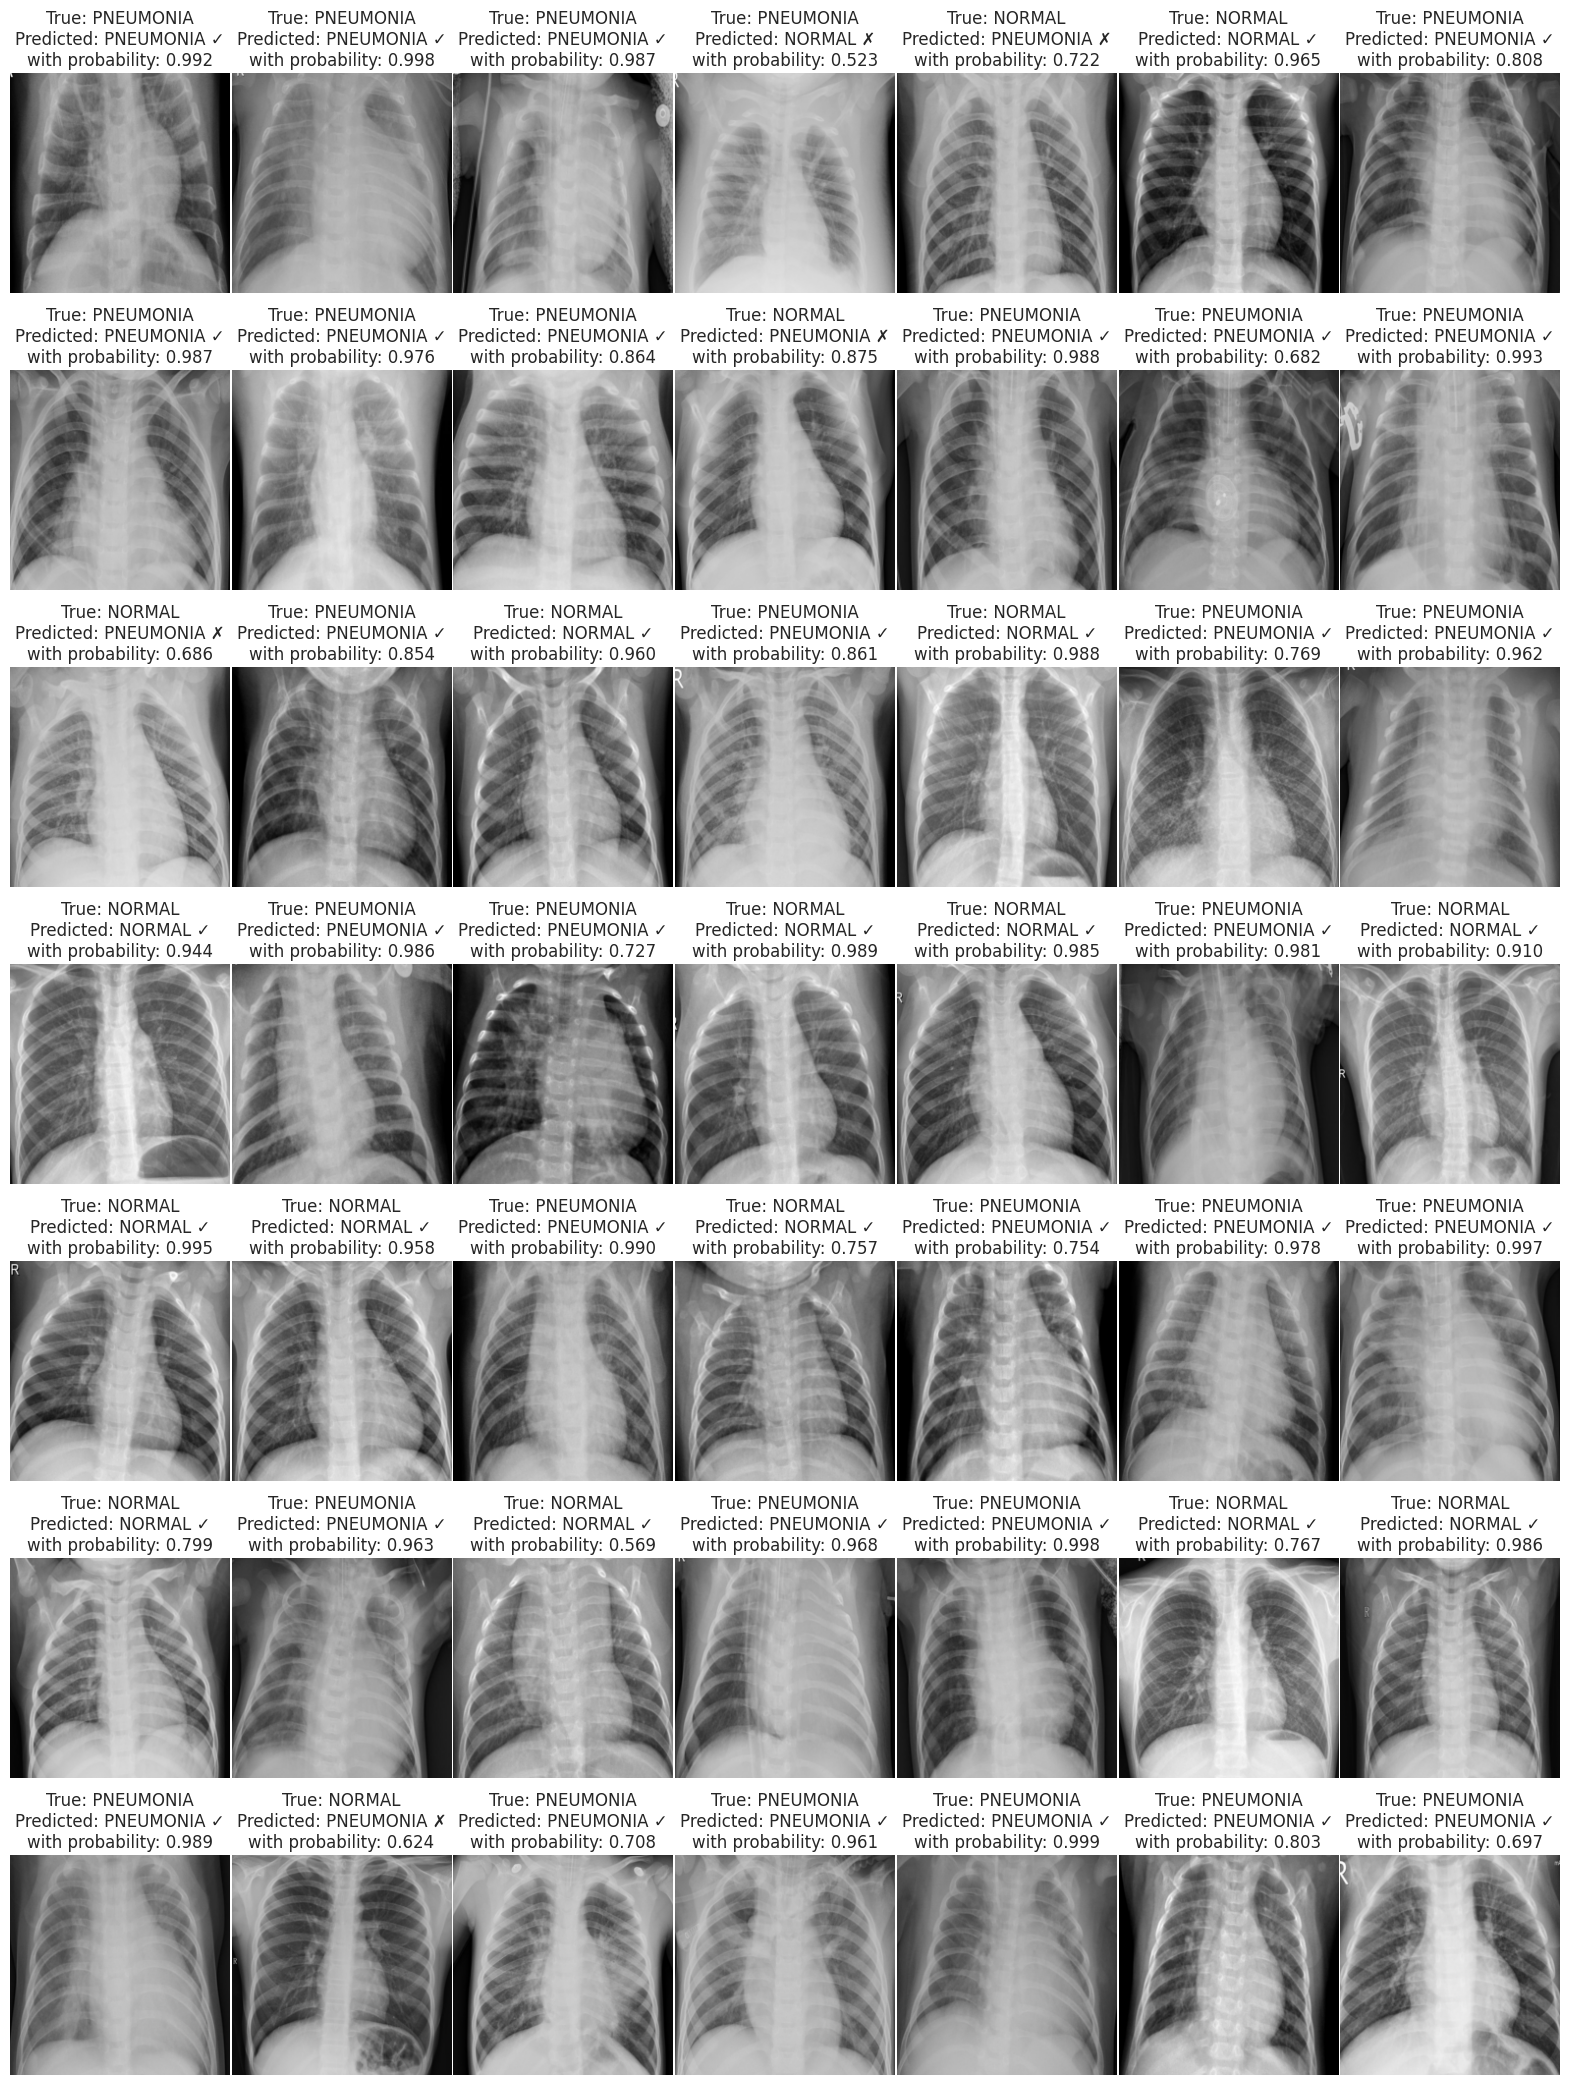

In [24]:
## Visualize some images with: true label, predicted label, probability

plt.figure(figsize=(20, 26))
n_rows = 7
n_cols = 7

# Display images
for i in range(n_rows*n_cols):
    text_true = 'True: ' + class_names[labels[i]]
    text_pred = '\nPredicted: ' + class_names[preds[i]]
    text_prob = '\nwith probability: ' + str(probs[i])[:5]

    if labels[i] == preds[i]:
        text_correct = ' ✓'
    else:
        text_correct = ' ✗'

    # Plot the image
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(np.transpose(images[0][i].numpy(), (1, 2, 0)))
    plt.title(text_true + text_pred + text_correct + text_prob)
    plt.axis('off')

plt.subplots_adjust(wspace=.01, hspace=.35)

### 7.3. Confusion matrix

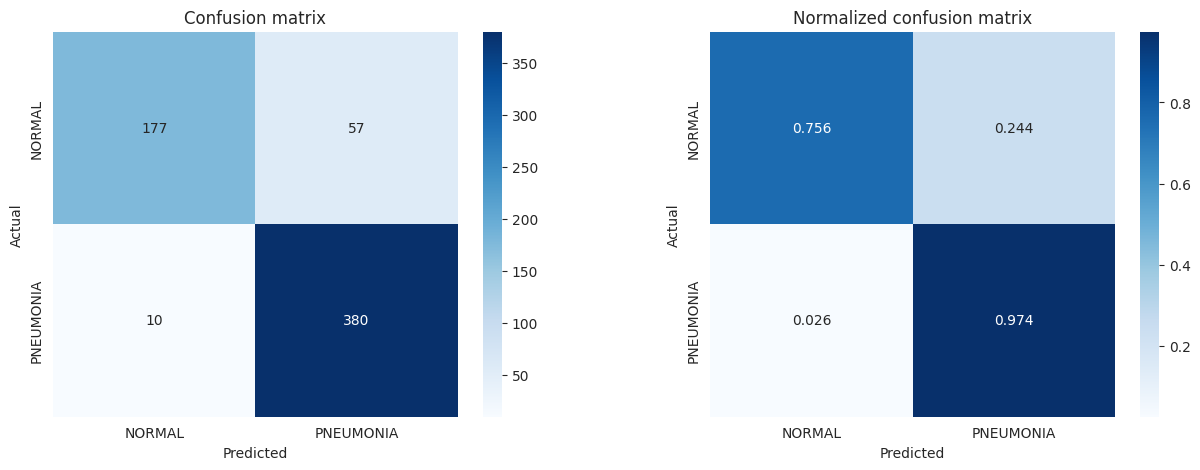

In [25]:
# Build the confusion matrix
cm = confusion_matrix(labels, preds)

# Normalize the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Ticklables
ticklabels = class_names.values()

# Plot
fig, ax = plt.subplots(figsize=(15,5))

# Confusion matrix
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

# Normalized confusion matrix
plt.subplot(1,2,2)
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Normalized confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

plt.subplots_adjust(wspace=.3)

## Conclusion

From the confusion matrix, we can see that the model has correctly predicted 174 normal cases, but it has misclassified some normal cases as pneumonia (60 cases) and some pneumonia cases as normal (50 cases). The matrix also shows that the model has correctly predicted 381 pneumonia cases, but it has misclassified some pneumonia cases as normal (250 cases).

Similarly, the precision for the pneumonia class is 0.4, which means that when the model predicts a pneumonia case, it is correct only 40% of the time. The recall for the pneumonia class is 0.977, which means that the model correctly identifies 97.7% of the pneumonia cases. The F1 score for the pneumonia class is 0.576.

Overall, the model performs well in identifying pneumonia cases but has a lower precision for the normal class. This means that the model may need to be adjusted to improve its performance in identifying normal cases.

